# Functions

In [135]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from tensorflow import keras
from keras import layers, Model
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    TensorBoard,
)

In [147]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


def load_data(file):
    df = pd.read_csv(file)
    df.drop(columns="Unnamed: 0", inplace= True)
    df = df.set_index("Date")
    return df

def fit_model(model, cp, epochs, xt, yt):
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    model.fit(xt, yt, epochs=epochs, callbacks=[cp])
    return model

def plot_val(model,Nsample, xv, yv):
    val_predictions = model.predict(xv).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':yv})
    plt.plot(val_results['Val Predictions'][:Nsample])
    plt.plot(val_results['Actuals'][:Nsample])
    plt.title("Validation")
    plt.show()
    
def plot_test(model, Nsample, xtt, ytt):
    test_predictions = model.predict(xtt).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':ytt})
    plt.plot(test_results['Test Predictions'][:Nsample])
    plt.plot(test_results['Actuals'][:Nsample])
    plt.title("Test")
    plt.show()
    
def plot_predictions1(model, X, y, start=0, end=100):
    prediction = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':prediction, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title("Predictions")
    plt.show()
    mse_v = mse(y, prediction)
    mae_v = mae(y, prediction)
    r2_v = r2(y, prediction)

    return mse_v, mae_v, r2_v


def plot_train(modelname, Nsample, xt, yt):
    model = load_model(modelname)
    train_predictions = model.predict(xt).flatten()
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':yt})
    plt.plot(train_results['Train Predictions'][:Nsample])
    plt.plot(train_results['Actuals'][:Nsample])
    plt.title("Train")
    plt.show()
    
def load_data_model(epochs):
    x_train = np.load(f"epochs{epochs}/x_train.npy")
    y_train = np.load(f"epochs{epochs}/y_train.npy")
    x_test  = np.load(f"epochs{epochs}/x_test.npy")
    y_test  = np.load(f"epochs{epochs}/y_test.npy")
    x_val   = np.load(f"epochs{epochs}/x_val.npy")
    y_val   = np.load(f"epochs{epochs}/y_val.npy")
    
    return x_train, y_train, x_test, y_test, x_val, y_val

def ae_predictions_max(model, X, y, start=0, end=100):
    prediction = model.predict(X)
    pred = [a.max() for a in prediction]
    df = pd.DataFrame(data={'Predictions':pred, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title("Predictions")
    plt.show()
    mse_v = mse(y, pred)
    mae_v = mae(y, pred)
    r2_v = r2(y, pred)

    return mse_v, mae_v, r2_v

def ae_predictions_mean(model, X, y, start=0, end=100):
    prediction = model.predict(X)
    pred = [a.mean() for a in prediction]
    df = pd.DataFrame(data={'Predictions':pred, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title("Predictions")
    plt.show()
    mse_v = mse(y, pred)
    mae_v = mae(y, pred)
    r2_v = r2(y, pred)

    return mse_v, mae_v, r2_v

def ae_predictions(model, X, y):
    prediction = model.predict(X)
    pred = c_value(prediction,y)
    plt.plot(pred)
    plt.plot(y)
    plt.title("Predictions")
    plt.show()
    mse_v = mse(y, pred)
    mae_v = mae(y, pred)
    r2_v = r2(y, pred)

    return mse_v, mae_v, r2_v

def c_value(predicted, y_test):
    closest_values = []

    for value in y_test:
        closest_value = None
        smallest_difference = float('inf')

        for data_list in predicted:
            differences = np.abs(np.subtract(value, data_list))
            closest_index = np.argmin(differences)
            current_difference = differences[closest_index]

            if current_difference < smallest_difference:
                smallest_difference = current_difference
                closest_value = data_list[closest_index]

        closest_values.append(closest_value)
    return closest_values


def save_history(history, fname):
    training_loss = history.history['loss']
    validation_loss = history.history.get('val_loss', None)  # Handle optional key
    training_acc = history.history.get('accuracy', None)  # Handle optional key
    validation_acc = history.history.get('val_accuracy', None)  # Handle optional key

    # Create a dictionary
    history_data = {
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'training_accuracy': training_acc,
        'validation_accuracy': validation_acc}
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(f"epochs{epochs}/history_{fname}.csv")

In [137]:
epochs = 50
x_train, y_train, x_test, y_test, x_val, y_val = load_data_model(epochs)
x_train.shape, y_train.shape

((228, 7, 1), (228,))

In [138]:
input_shape = (7,1)

# AE

## LSTM

In [ ]:
model = Sequential([
    LSTM(32, activation= "relu", input_shape= input_shape, return_sequences= True),
    LSTM(16, activation= "relu", return_sequences= False),
    RepeatVector(25),
    LSTM(16, activation= "relu", return_sequences= True),
    LSTM(32, activation= "relu", return_sequences= True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_lstm")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)



3/3 [==============================] - 0s 10ms/step


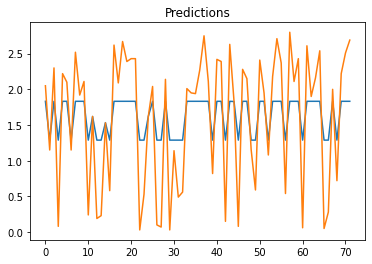

In [143]:
lstm_mse, lstm_mae, lstm_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_lstm")

## CNN

INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_cnn/assets


3/3 [==============================] - 0s 6ms/step


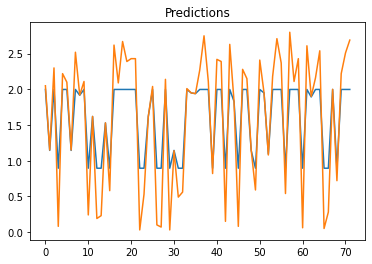

In [149]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape),
    MaxPooling1D(pool_size=2), 
    Flatten(),  
    RepeatVector(25), 
    Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
    UpSampling1D(size=2),  
    Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"),
    TimeDistributed(Dense(1))  
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_cnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)
cnn_mse, cnn_mae, cnn_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_cnn")

## RNN

INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_rnn/assets


3/3 [==============================] - 1s 15ms/step


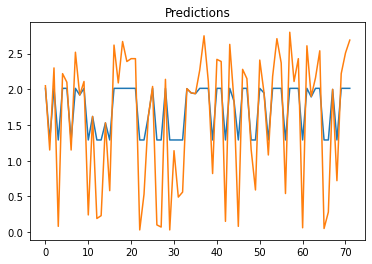

In [150]:
model = Sequential([
    SimpleRNN(32, activation="relu", input_shape=input_shape, return_sequences=True),
    SimpleRNN(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    SimpleRNN(16, activation="relu", return_sequences=True),
    SimpleRNN(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_rnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_rnn")

## GRU

INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_gru/assets


3/3 [==============================] - 2s 118ms/step


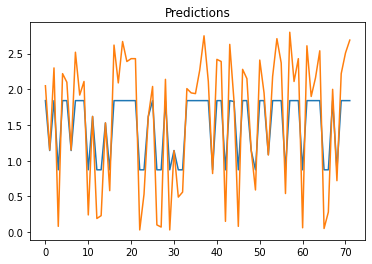

In [151]:
model = Sequential([
    GRU(32, activation="relu", input_shape=input_shape, return_sequences=True),
    GRU(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    GRU(16, activation="relu", return_sequences=True),
    GRU(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_gru"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_gru")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_gru")

# Moving Average AE

In [152]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=x_train)
target = y_train[window_size - 1:].flatten()

In [153]:
moving_avg_data.shape, target.shape

((224, 7, 1), (224,))

## LSTM

INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_lstm/assets


7/7 [==============================] - 1s 14ms/step


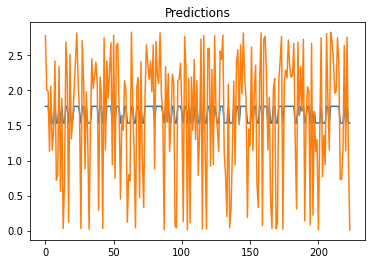

In [154]:
model = Sequential([
    LSTM(32, activation= "relu", input_shape= input_shape, return_sequences= True),
    LSTM(16, activation= "relu", return_sequences= False),
    RepeatVector(25),
    LSTM(16, activation= "relu", return_sequences= True),
    LSTM(32, activation= "relu", return_sequences= True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_lstm")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

lstm_mse, lstm_mae, lstm_r2 = ae_predictions(model,moving_avg_data, target)
save_history(history, "ae_mavg_lstm")

## CNN

INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_cnn/assets


7/7 [==============================] - 0s 5ms/step


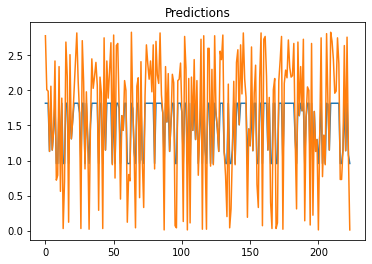

In [155]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape),
    MaxPooling1D(pool_size=2), 
    Flatten(),  
    RepeatVector(25), 
    Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
    UpSampling1D(size=2),  
    Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"),
    TimeDistributed(Dense(1))  
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_cnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)
cnn_mse, cnn_mae, cnn_r2 = ae_predictions(model, moving_avg_data, target)
save_history(history, "ae_mavg_cnn")

## RNN

INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_rnn/assets
2024-04-11 05:21:27.456448: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_19/simple_rnn_8/while/body/_1/sequential_19/simple_rnn_8/while/simple_rnn_cell_8/Relu}}
	.  Registered:  <no registered kernels>

2024-04-11 05:21:27.458499: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_19/simple_rnn_9/while/body/_44/sequential_19/simple_rnn_9/while/simple_rnn_cell_9/Relu}}
	.  Registered:  <no registered kernels>

2024-04-11 05:21:27.460557: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_19/simple_rnn_10/while/body/_87/sequential_19/simple_rnn_10/while/simple_rnn_cell_10/Relu}}
	.  Registered:  <no registered kernels>

2024-04-11 05:21:27.462709: W tensorflow/core/grappler/util

7/7 [==============================] - 1s 9ms/step


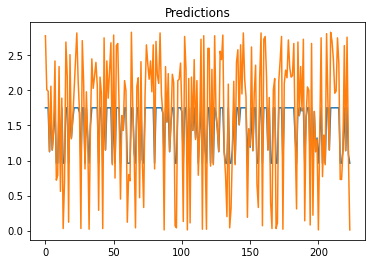

In [156]:
model = Sequential([
    SimpleRNN(32, activation="relu", input_shape=input_shape, return_sequences=True),
    SimpleRNN(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    SimpleRNN(16, activation="relu", return_sequences=True),
    SimpleRNN(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_rnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, moving_avg_data, target)
save_history(history, "ae_mavg_rnn")

## GRU

INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_gru/assets


7/7 [==============================] - 1s 10ms/step


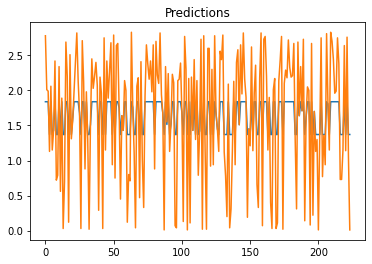

In [157]:
model = Sequential([
    GRU(32, activation="relu", input_shape=input_shape, return_sequences=True),
    GRU(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    GRU(16, activation="relu", return_sequences=True),
    GRU(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_gru"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_gru")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, moving_avg_data, target)
save_history(history, "ae_mavg_gru")

# AE DReg

## LSTM

INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_lstm/assets


3/3 [==============================] - 1s 12ms/step


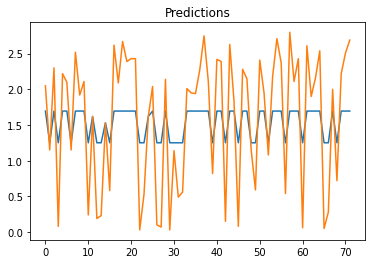

In [158]:
model = Sequential([
    LSTM(32, activation= "relu", input_shape= input_shape, return_sequences= True),
    LSTM(16, activation= "relu", return_sequences= False),
    RepeatVector(25),
    LSTM(16, activation= "relu", return_sequences= True),
    LSTM(32, activation= "relu", return_sequences= True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_dreg_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_dreg_lstm")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

lstm_mse, lstm_mae, lstm_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_dreg_lstm")

## CNN

INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_cnn/assets


3/3 [==============================] - 0s 5ms/step


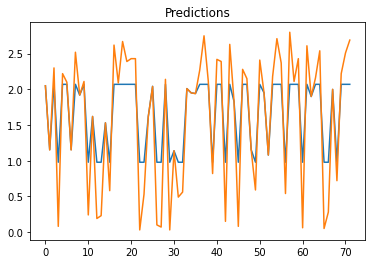

In [159]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape),
    MaxPooling1D(pool_size=2), 
    Flatten(),  
    RepeatVector(25), 
    Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
    UpSampling1D(size=2),  
    Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"),
    TimeDistributed(Dense(1))  
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_dreg_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_dreg_cnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)
cnn_mse, cnn_mae, cnn_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_dreg_cnn")

## RNN

INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_rnn/assets


3/3 [==============================] - 1s 12ms/step


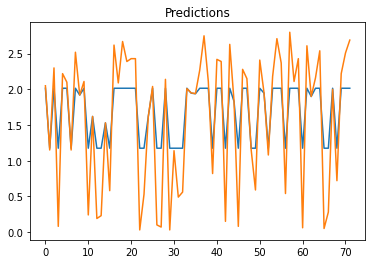

In [160]:
model = Sequential([
    SimpleRNN(32, activation="relu", input_shape=input_shape, return_sequences=True),
    SimpleRNN(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    SimpleRNN(16, activation="relu", return_sequences=True),
    SimpleRNN(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_dreg_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_dreg_rnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_dreg_rnn")

## GRU

INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_dreg_gru/assets


3/3 [==============================] - 1s 46ms/step


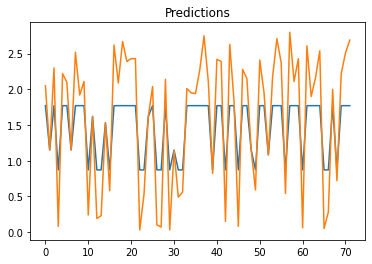

In [161]:
model = Sequential([
    GRU(32, activation="relu", input_shape=input_shape, return_sequences=True),
    GRU(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    GRU(16, activation="relu", return_sequences=True),
    GRU(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_dreg_gru"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_dreg_gru")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, x_test, y_test)
save_history(history, "ae_dreg_gru")

# MA AE DReg

INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_lstm/assets


7/7 [==============================] - 1s 11ms/step


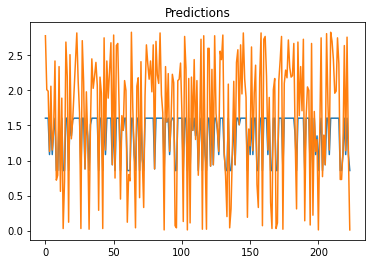

In [162]:
model = Sequential([
    LSTM(32, activation= "relu", input_shape= input_shape, return_sequences= True),
    LSTM(16, activation= "relu", return_sequences= False),
    RepeatVector(25),
    LSTM(16, activation= "relu", return_sequences= True),
    LSTM(32, activation= "relu", return_sequences= True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_dreg_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_dreg_lstm")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

lstm_mse, lstm_mae, lstm_r2 = ae_predictions(model,moving_avg_data, target)
save_history(history, "ae_mavg_dreg_lstm")

## CNN

INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_cnn/assets


7/7 [==============================] - 0s 4ms/step


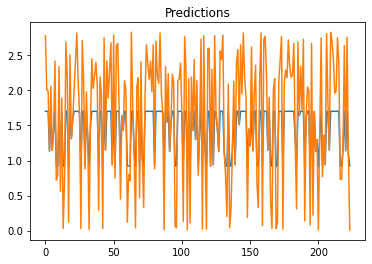

In [163]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape),
    MaxPooling1D(pool_size=2), 
    Flatten(),  
    RepeatVector(25), 
    Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
    UpSampling1D(size=2),  
    Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"),
    TimeDistributed(Dense(1))  
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_dreg_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_dreg_cnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)
cnn_mse, cnn_mae, cnn_r2 = ae_predictions(model, moving_avg_data, target)
save_history(history, "ae_mavg_dreg_cnn")

## RNN

INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_rnn/assets


7/7 [==============================] - 1s 7ms/step


2024-04-11 05:45:50.535537: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_27/simple_rnn_18/while/body/_87/sequential_27/simple_rnn_18/while/simple_rnn_cell_18/Relu}}
	.  Registered:  <no registered kernels>

2024-04-11 05:45:50.540395: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_27/simple_rnn_17/while/body/_44/sequential_27/simple_rnn_17/while/simple_rnn_cell_17/Relu}}
	.  Registered:  <no registered kernels>

2024-04-11 05:45:50.542281: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_27/simple_rnn_16/while/body/_1/sequential_27/simple_rnn_16/while/simple_rnn_cell_16/Relu}}
	.  Registered:  <no registered kernels>

2024-04-11 05:45:50.544232: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU de

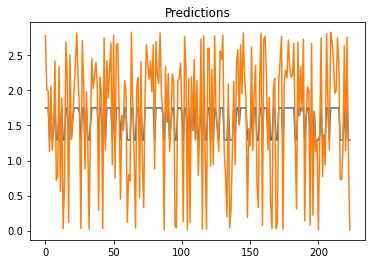

In [164]:
model = Sequential([
    SimpleRNN(32, activation="relu", input_shape=input_shape, return_sequences=True),
    SimpleRNN(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    SimpleRNN(16, activation="relu", return_sequences=True),
    SimpleRNN(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_dreg_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_dreg_rnn")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, moving_avg_data, target)
save_history(history, "ae_mavg_dreg_rnn")

## GRU

INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


INFO:tensorflow:Assets written to: epochs50/ae_mavg_dreg_gru/assets


7/7 [==============================] - 1s 13ms/step


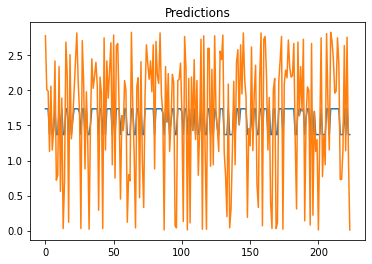

In [165]:
model = Sequential([
    GRU(32, activation="relu", input_shape=input_shape, return_sequences=True),
    GRU(16, activation="relu", return_sequences=False),
    RepeatVector(25),
    GRU(16, activation="relu", return_sequences=True),
    GRU(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

mname = f"epochs{epochs}/ae_mavg_dreg_gru"
cp = ModelCheckpoint(mname, save_best_only=True)  # Saves the best model based on validation loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5)  # Stops training if validation loss doesn't improve for 5 epochs
tensorboard = TensorBoard(log_dir="logs/ae_mavg_dreg_gru")  # Logs training and validation metrics for visualization

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose = 0,
    validation_data=(x_val, y_val),
    callbacks=[cp, early_stopping, tensorboard],
)

rnn_mse, rnn_mae, rnn_r2 = ae_predictions(model, moving_avg_data, target)
save_history(history, "ae_mavg_dreg_gru")